In [43]:
import matplotlib.pyplot as plt
import pde
import numpy as np
import torch
torch.manual_seed(0)
import pandas as pd
from torch.nn import functional as F


from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

plt.rcParams['figure.figsize'] = [6, 6]

In [42]:
def solveEquationPYPDE(variable, eq, ic="2/cosh(x)**2", xrange=None, yrange=None, points=300, trange=2):
    #initialize xrangenp.linspace(0, 10, 100).reshape(-1, 1)
    if xrange is None:
        xrange = [-pi, 3 * pi]

    # define an interval
    inter = trange/300
    
    #eq is passed in as a string with x as the dependent variable
    eq = pde.PDE({variable: eq})
    
    if yrange is not None:
        grid = pde.grids.CartesianGrid([xrange, yrange], [points], periodic=[True, True])
    else:
        grid = pde.grids.CartesianGrid([xrange], [points],  periodic=True)
    
    field = pde.ScalarField.from_expression(grid, ic)
    bc = ["periodic", {'derivative': 'periodic'}]
    #field /= np.sqrt(field.to_scalar('norm_squared').integral.real)

    storage = pde.MemoryStorage()
    trackers = ['progress', storage.tracker(interval = inter)]
    
    solver = pde.ExplicitSolver(eq, backend='numba' ,scheme='runge-kutta', adaptive=True, tolerance=1e-9)
    controller = pde.Controller(solver, t_range=trange, tracker=trackers)
    solution = controller.run(field, dt=1e-4)
    
    return field, storage

In [5]:
s1, st1 = solveEquationPYPDE('phi', f"- 6 * phi * d_dx(phi) - laplace(d_dx(phi))")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.0/2.0 [00:19<00:00,  9.62s/it]


(301, 300)


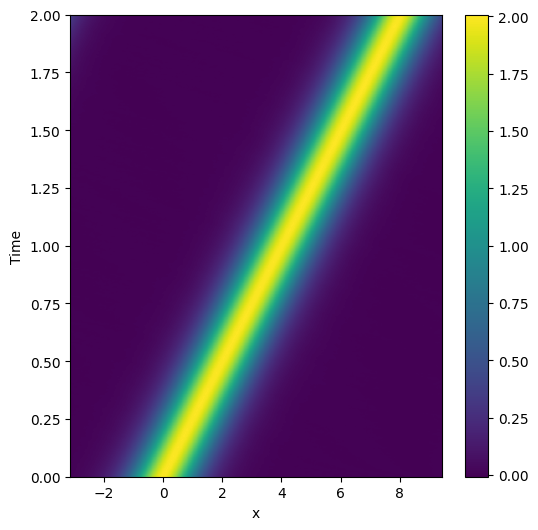

In [7]:
print(np.array(st1.data).shape)
pde.plot_kymograph(st1)

In [8]:
numerical = np.array(st1.data)[:300,:]

In [9]:
x = s1.get_line_data()['data_x'].reshape(-1,1) # X x 1
t = np.array(st1.times).reshape(-1,1) # T x 1
x_grid, t_grid = np.meshgrid(x, t)


phi = np.array(st1.data)
#u = np.real(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)   #.flatten()[:,None]
#v = np.imag(phi) #.flatten().reshape(-1,1)[::10].reshape(79,30)  #.flatten()[:,None]

#plt.pcolormesh(x_grid, t_grid, np.sqrt(u**2 + v**2))

##Generate the two indices
idx1 = np.random.choice(x_grid.shape[0], 100, replace=False)
idx1 = np.sort(idx1)
idx2 = np.random.choice(x_grid.shape[1], 105, replace=False)
idx2 = np.sort(idx2)

def gen_train(grid):
    grid_new = grid[idx1]
    grid_new = grid_new[:,idx2]
    return grid_new
    
x_train, t_train, phi_train = gen_train(x_grid), gen_train(t_grid), gen_train(phi)

## attempt to plot
##plt.pcolormesh(x_train, t_train, phi_train)

In [10]:
## reshape to feed into model
x_train = x_train.flatten()[:,None]
t_train = t_train.flatten()[:,None]

phi_train = phi_train.flatten()[:,None]
print(x_train.shape, t_train.shape, phi_train.shape)

(10500, 1) (10500, 1) (10500, 1)


In [11]:
def preds_and_errors(model, err=1):
    #with torch.cuda.amp.autocast():
    pred = model.net(xt_pairs).reshape((300,300)).detach().cpu()
    
    #absval = torch.sqrt(pred[:,0:1]**2 + pred[:,1:2]**2).reshape((100,100)).detach().cpu()
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, layout='constrained')
    fig.set_figwidth(12)
    #fig.suptitle('Horizontally stacked subplots')
    ax1.set_title("Predicted")
    ax1.set_xlabel("x")
    ax1.set_ylabel("t")
    p1 = ax1.pcolormesh(x_grid.numpy(), t_grid.numpy(), pred.numpy())
    plt.colorbar(p1, ax=ax1)
    ax2.set_title("Error")
    ax2.set_xlabel("x")
    p2 = ax2.pcolormesh(x_grid.numpy(), t_grid.numpy(),  np.abs(pred.numpy()-numerical)/err)
    plt.colorbar(p2, ax=ax2)
    plt.show()

In [51]:
## boilerplate stuff for GPU...
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

## create gridmesh for plotting
x_axis = torch.linspace(-pi, 3 * pi, 300, dtype=torch.float32)##, dtype=torch.float16)
t_axis = torch.linspace(0, 2, 300, dtype=torch.float32)##, dtype=torch.float16)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

class PINN():
    def __init__(self, x, t, phi, dDim=256, nHid=4):
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True, device=device) ## dtype=torch.float16,
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True, device=device) ## dtype=torch.float16,
        
        self.phi = torch.tensor(phi, dtype=torch.float32, device=device) ##  dtype=torch.float16,
        
        self.null = torch.zeros((self.x.shape[0],1), dtype=torch.float32, device=device) ##  dtype=torch.float16,

        
        ##initialize the unknown coefficients
        self.lam1 = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32, requires_grad=True, device=device)) ## dtype=torch.float16,
        self.lam2 = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32, requires_grad=True, device=device)) ## dtype=torch.float16,
        self.lams1 = []
        self.lams2 = []
        
        self.dDim = dDim
        self.nHid = nHid
        self.net_init()
        #self.optim = torch.optim.LBFGS(self.net.parameters(),
        #                               lr=0.01,
        #                               max_iter=50000,
        #                               max_eval=50000,
        #                               history_size=50,
        #                               tolerance_grad=1e-8,
        #                               tolerance_change=0.5 * np.finfo(float).eps,
        #                               line_search_fn='strong_wolfe'
        #                              )

        self.optim = torch.optim.Adam(list(self.net.parameters()) + [self.lam1, self.lam2], lr=1e-4)
        ## list(self.net.parameters()) + [self.lam1, self.lam2]
        
        self.mse = torch.nn.MSELoss()
        self.loss = []
        self.ls = 0
        self.step = 0
    
    def net_init(self, act=torch.nn.Tanh):
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, self.dDim), act(),
            torch.nn.Sequential(*[
                torch.nn.Sequential(*[
                    torch.nn.Linear(self.dDim, self.dDim), act()
            ]) for _ in range(self.nHid)]),
            torch.nn.Linear(self.dDim, 1)
        )

        for module in self.net.modules():
            if isinstance(module, act):
                module = torch.cuda.amp.autocast()(module)
        
        self.net.to(device)

    
    def func(self, x, t):
        ##with torch.cuda.amp.autocast():
        phi = self.net(torch.hstack((x, t)))

        phi_t = torch.autograd.grad(phi, t, torch.ones_like(phi), create_graph=True)[0]
        phi_x = torch.autograd.grad(phi, x, torch.ones_like(phi), create_graph=True)[0]
        phi_xx = torch.autograd.grad(phi_x, x, torch.ones_like(phi_x), create_graph=True)[0]
        phi_xxx = torch.autograd.grad(phi_xx, x, torch.ones_like(phi_xx), create_graph=True)[0]

        f_phi = phi_t + self.lam1 * phi * phi_x + self.lam2 * phi_xxx
        return phi, f_phi
        
    def closure(self):
        ## with torch.cuda.amp.autocast(dtype=torch.float16):
        self.optim.zero_grad(set_to_none=True)
        phi_pred, f_phi_pred = self.func(self.x, self.t)
        phi_loss = self.mse(phi_pred, self.phi)
        f_phi_loss = self.mse(f_phi_pred, self.null)
        self.ls = phi_loss + 10 * f_phi_loss
        self.ls.backward()

        if not self.step % 1000:
            print(f"Step: {self.step}, Loss: {self.ls}")
            print(f"Data loss: {phi_loss}, Phi loss: {f_phi_loss}")
            print(f"Lam1: {round(self.lam1.item(),4)}, lam2: {round(self.lam2.item(),4)}")
        
        if not self.step % 5000:
            preds_and_errors(self)
            f, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
            ax1.plot(kdv.lams1)
            ax1.set_title('lam1')
            ax2.plot(kdv.lams2)
            ax2.set_title('lam2')
            plt.show()

        self.loss.append(self.ls.item())
        self.lams1.append(self.lam1.item())
        self.lams2.append(self.lam2.item())
        self.step += 1
        return self.ls

    def train(self):
        self.net.train()
        for i in range(5001):
            self.optim.step(self.closure)

In [52]:
kdv = PINN(x_train, t_train, phi_train, nHid=8, dDim=128)

Step: 6000, Loss: 0.2596801519393921
Data loss: 0.25403639674186707, Phi loss: 0.000564376066904515
Lam1: 0.4319, lam2: 0.476
Step: 7000, Loss: 0.257031112909317
Data loss: 0.2512756288051605, Phi loss: 0.0005755493184551597
Lam1: 0.4735, lam2: 0.5245
Step: 8000, Loss: 0.2543182373046875
Data loss: 0.24853840470314026, Phi loss: 0.0005779820494353771
Lam1: 0.5111, lam2: 0.5708
Step: 9000, Loss: 0.2515197992324829
Data loss: 0.2460220456123352, Phi loss: 0.000549775140825659
Lam1: 0.5449, lam2: 0.6163
Step: 10000, Loss: 0.24805234372615814
Data loss: 0.24171900749206543, Phi loss: 0.0006333329947665334
Lam1: 0.5718, lam2: 0.6624


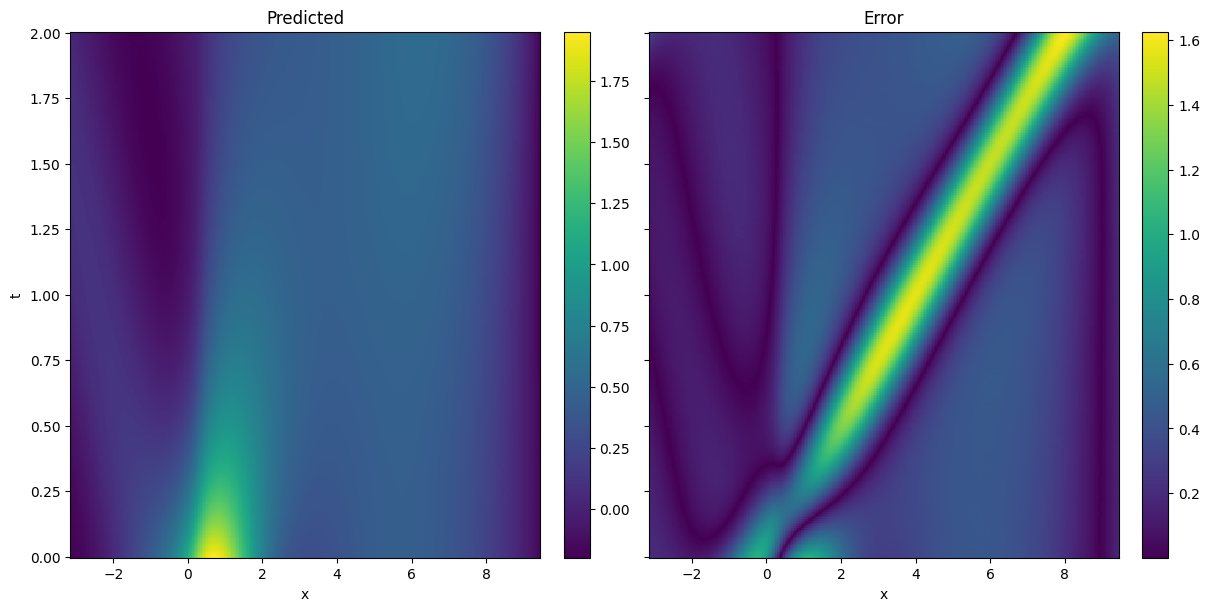

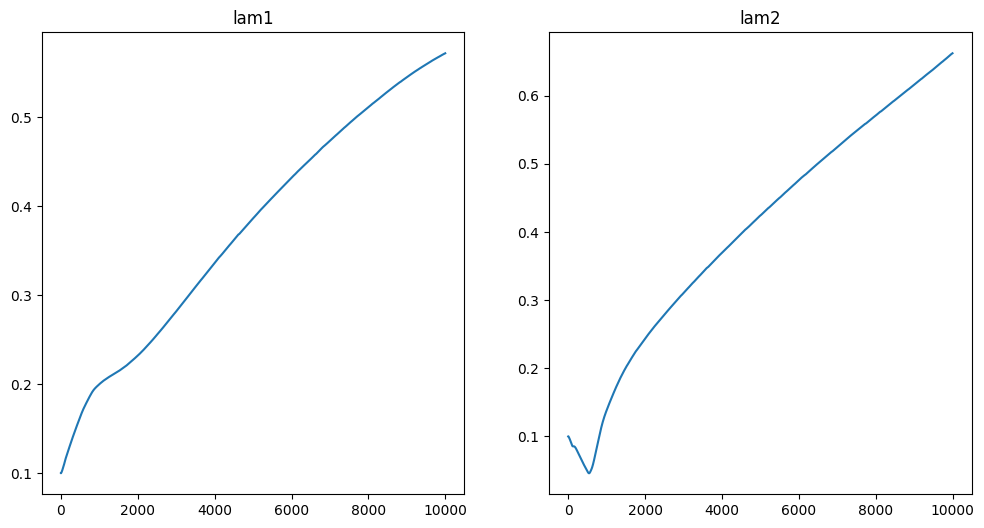

Step: 11000, Loss: 0.25828590989112854
Data loss: 0.24060049653053284, Phi loss: 0.0017685401253402233
Lam1: 0.5938, lam2: 0.7147
Step: 12000, Loss: 0.23855158686637878
Data loss: 0.23247382044792175, Phi loss: 0.00060777657199651
Lam1: 0.6168, lam2: 0.7661
Step: 13000, Loss: 0.2345205545425415
Data loss: 0.22900734841823578, Phi loss: 0.000551320961676538
Lam1: 0.6401, lam2: 0.8112
Step: 14000, Loss: 0.23081117868423462
Data loss: 0.2246788740158081, Phi loss: 0.0006132305134087801
Lam1: 0.6632, lam2: 0.8506
Step: 15000, Loss: 0.22767716646194458
Data loss: 0.22181695699691772, Phi loss: 0.0005860216915607452
Lam1: 0.6852, lam2: 0.8863


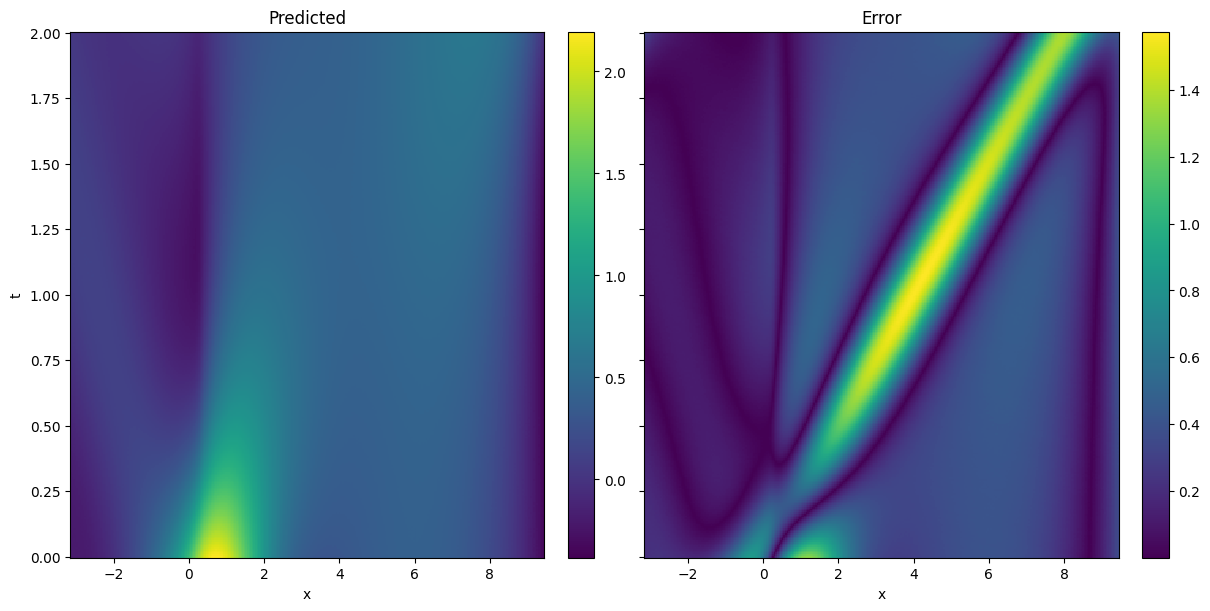

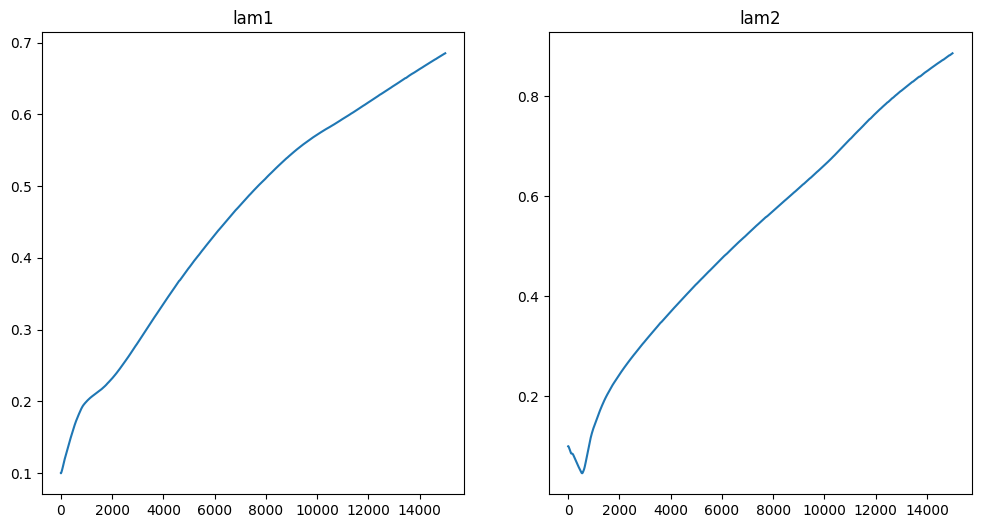

Step: 16000, Loss: 0.22570998966693878
Data loss: 0.2204255908727646, Phi loss: 0.0005284404032863677
Lam1: 0.7064, lam2: 0.9186
Step: 17000, Loss: 0.22563619911670685
Data loss: 0.21932461857795715, Phi loss: 0.0006311586475931108
Lam1: 0.7277, lam2: 0.9517
Step: 18000, Loss: 0.2222200483083725
Data loss: 0.2156095653772354, Phi loss: 0.0006610475829802454
Lam1: 0.7507, lam2: 0.9839
Step: 19000, Loss: 0.21965797245502472
Data loss: 0.21342629194259644, Phi loss: 0.0006231680163182318
Lam1: 0.7755, lam2: 1.0165


In [ ]:
%%time
for _ in range(9):
    kdv.train()

## fp32 precision (500 epochs) took 57.5 s
## fp16 precision (500 epochs) took 28.6 s

In [43]:
x_axis = torch.linspace(-pi, 3*pi, 300)
t_axis = torch.linspace(0, 2, 300)

x_grid, t_grid = torch.meshgrid(x_axis, t_axis, indexing='xy')
xt_pairs = torch.stack((x_grid, t_grid), dim=2)
xt_pairs = xt_pairs.reshape(xt_pairs.shape[0] * xt_pairs.shape[1],2).to(device)

phi = kdv.net(xt_pairs).reshape((100,100)).detach().cpu()

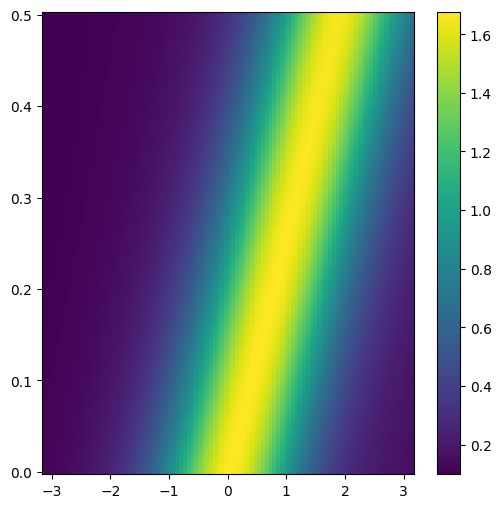

In [44]:
plt.pcolormesh(x_grid, t_grid, phi)
plt.colorbar()
plt.show()

In [30]:
kdv.ls

tensor(0.7802, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns=[2,4,6,8,10])
for n_layers in [2,4,6,8,10]:
    print('%%%%%%%%%%%%%%%')
    print(str(n_layers))
    print('%%%%%%%%%%%%%%%')
    tmp = []
    for dim in [32,64,128,256]:
        print('########' + str(dim) + '##########')
        model = PINN(x_train, t_train, phi_train, dDim=dim, nHid=n_layers)
        model.train()
        tmp.append(model.ls.item())
    df[n_layers] = pd.Series(tmp)

df

In [ ]:
kdv.ls.item()

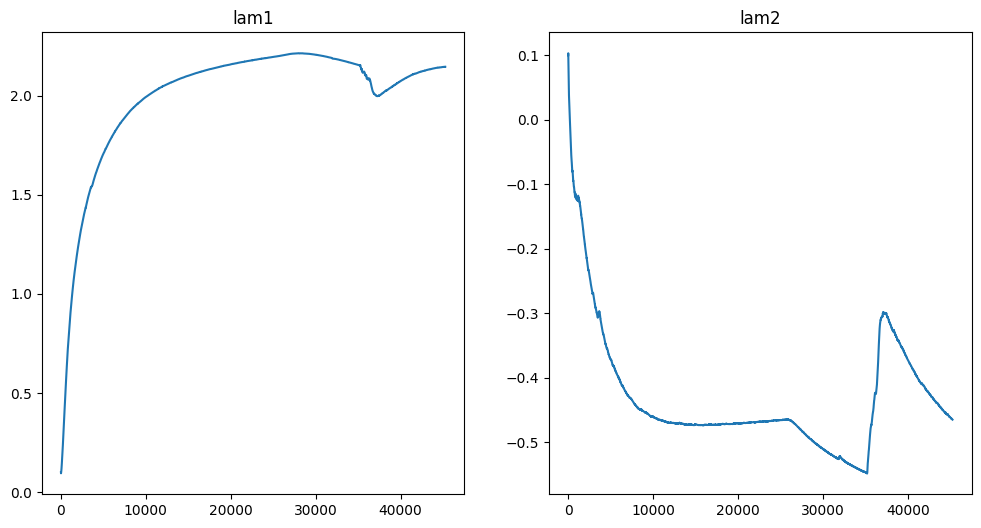

In [ ]:
torch.linspace(-pi, 2*pi, 100).dtype

In [ ]:
lst = torch.nn.Sequential(*[torch.nn.Sequential(*[torch.nn.Linear(10, 10), torch.nn.Tanh()]) for _ in range(3)])
lst

In [ ]:
torch.tensor(0, dtype=torch.float16, requires_grad=True, device=device)

In [ ]:
kdv.net

In [38]:
35*60 + 6 + 34*60 + 2 + 33*60 + 17

6145

In [29]:
round(kdv.lam2.item(),4)

0.0627